In [1]:
import numpy as np # library for data structures, vectors, matrices and mathematical functions
import matplotlib.pyplot as plt                   # library for plotting and visual representation
import matplotlib.transforms as transform                   # library for plotting and visual representation
from matplotlib import rcParams                   # module handling generic plot parameters
from matplotlib.ticker import (FormatStrFormatter)# module for figure axis formatting
import pandas as pd                               # data administration, here used for data import
from scipy.optimize import curve_fit              # fitting algorithm from the scipy package
from scipy.signal import find_peaks
from scipy.special import fresnel
from IPython.display import display as dy, Markdown as md, Latex as Lx, Image as Im, HTML as hm # displaying LaTeX code in code cells
import sympy as sp
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 15,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'figure.figsize': (10,6),
                    })

plt.rcParams['axes.facecolor'] = 'black' 
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['grid.color'] = '#707070'
plt.rcParams['axes.titlepad'] = 20
legendfontsize=12

ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}

# O17e Diffraction

Group #13

NG Kuok Fung | #3797903 

Edgar Harutyunyan | #3775171

**Overview of Tasks**

***Task 0***

- Analytically calculate the Fourier transform of a single-slit and a double-slit function, and compare these with the familiar Fraunhofer diffraction-patterns for these objects. 

- Using FFT (Fast-Fourier-Transform), determine the Fourier transforms of the functions $F(k) = sinc(2\pi k) = sin(2\pi k)/(2\pi k)$ and $F^2(k)$. Discuss this result in the light of the convolution theorem.

***Task 1***

Measure the diffraction pattern of a single-slit in the Fraunhofer regime, and for three distances $z$ between slit and camera in the Fresnel regime.

In the Fraunhofer regime, determine the slit width $b$: 

(a) From the position of the minima for various diffraction orders

(b) From the FFT of the intensity profile.
    
In the Fresnel regime,
    
(c) Compare the measured diffraction patterns with the theory.


***Task 2***

Measure the diffraction pattern of a double-slit in the Fraunhofer regime, and for three distances between slit and camera in the Fresnel regime.

In the Fraunhofer regime, determine:
    
(a) the slit distance $g$ from the position of the minima for various diffraction orders
    
(b) the slit distance $g$ and the slit width $b$ from the fit of the Fraunhofer diffraction-pattern to the data
    
(c) the slit distance $g$ and the slit width $b$ from the FFT of the intensity profile.

In the Fresnel regime,
    
(d) compare the measured diffraction patterns with the theory.

In [2]:
# GLOBALS
data_dir = './data/'
Lambda = 635e-9 # m
f = 300.8e-3 # m
ds_g_th = 0.25e-3 # m double-slit given g
ds_b_a_th = 0.1e-3 # m double-slit given b_a
ds_b_b_th = 0.15e-3 # m double-slit given b_b
pw = 7e-6 # m pixel width
cp = 34 # mm camera position
z1 = (422 - cp) * 1e-3 # m
z2 = (337 - cp) * 1e-3 # m
z3 = (460 - cp) * 1e-3 # m
z_l = [z1, z2, z3]

def fit_and_plot(x,y, xlabel, ylabel, title, fit_func):
    plt.scatter(x, y, color='#ADD8E6',marker='x', label=r'Data')
    #plt.scatter(df[x_col], df[y_col], color=color,marker='x', label=f'{ylabel[:-4]} vs {xlabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Perform non-linear regression using curve_fit
    params, cov_mat = curve_fit(fit_func, x, y)
    
    # Plot the fitted curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, *params)
    plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')
    plt.legend()
    plt.show()
    return [params, cov_mat]

### Task 0

***Task Definition***

Analytically calculate the Fourier transform of a single-slit and a double-slit function and compare these with the familiar Fraunhofer diffraction-patterns for these objects. Using FFT (Fast-Fourier-Transform), determine the Fourier transforms of the functions $F(k) = sinc(2\pi k) = sin(2\pi k)/(2\pi k)$ and $F^2(k)$. Discuss this result in the light of the convolution theorem.

For a single-slit aperture of width $b$:
$$
f(x)=rect\left(\frac{x}{b}\right) =
\begin{cases}
1, -b/2 \le x \le b/2\\
0, \text{otherwise}\\
\end{cases}
\label{eqi.1} \tag{i.1}
$$

For a double-slit aperture with slit separation $g$ and slit width $b$:

$$
f(x)=rect\left(\frac{x+g/2}{b}\right) + rect\left(\frac{x - g/2}{b}\right) =
\begin{cases}
1, -(g+b)/2 \le x \le -(g-b)/2\\
1, (g-b)/2 \le x \le (g+b)/2\\
0, \text{otherwise}\\
\end{cases}
\label{eqi.2} \tag{i.2}
$$


The Fourier transform $F(k)$ of $f(x)$ is given by:

$$F(k) = \int_{-\infty}^{\infty}f(x)e^{-i kx}dx \label{eqi.3} \tag{i.3}$$

For the single-slit function [Eq i.1](#mjx-eqn-eqi.1):

$$F(k) = \int_{-b/2}^{b/2}e^{-i kx}dx = \frac{e^{-ikx}}{-ik} \bigg|_{x=-b/2}^{x=b/2} = \frac{b}{kb/2}\frac{e^{-ikb/2} - e^{ikb/2}}{-2i} = \frac{b\sin(kb/2)}{kb/2}$$

$$F(k) = b sinc\left(k\frac{b}{2}\right) \label{eqi.4} \tag{i.4}$$

For the double-slit function [Eq i.2](#mjx-eqn-eqi.2):

$$F(k) = \int_{-(g+b)/2}^{-(g-b)/2}e^{-ikx}dx + \int_{(g-b)/2}^{(g+b)/2}e^{-ikx}dx = \frac{e^{-ikx}}{-ik} \bigg|_{x=-(g+b)/2}^{x=-(g-b)/2} + \frac{e^{-ikx}}{-ik}\bigg|_{x=(g-b)/2}^{x=(g+b)/2} = \frac{e^{ikg/2}}{k/2}\frac{e^{ikb/2}-e^{-ikb/2}}{2i} + \frac{e^{-ikg/2}}{k/2}\frac{e^{ikb/2}-e^{-ikb/2}}{2i} =$$

$$ = b\frac{\sin(kb/2)}{kb/2}\left(e^{ikg/2}+e^{-ikg/2}\right) = b\frac{\sin(kb/2)}{kb/2}2\cos{\left(kg/2\right)}$$


$$F(k) = 2b sinc\left(k\frac{b}{2}\right) \cos{\left(k\frac{g}{2}\right)} \label{eqi.5} \tag{i.5}$$


The convolution theorem states that the Fourier transform of a convolution of two functions is the product of their Fourier transforms. This will be illustrated by comparing the results from $sinc(kb/2)$ and $sinc^2(kb/2)$.

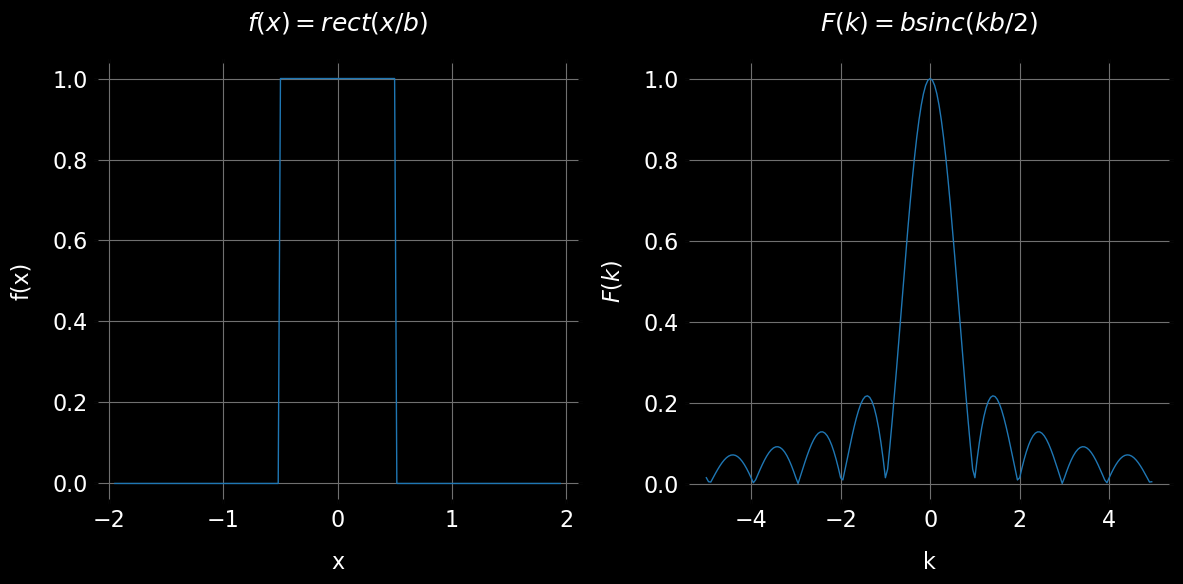

<IPython.core.display.Latex object>

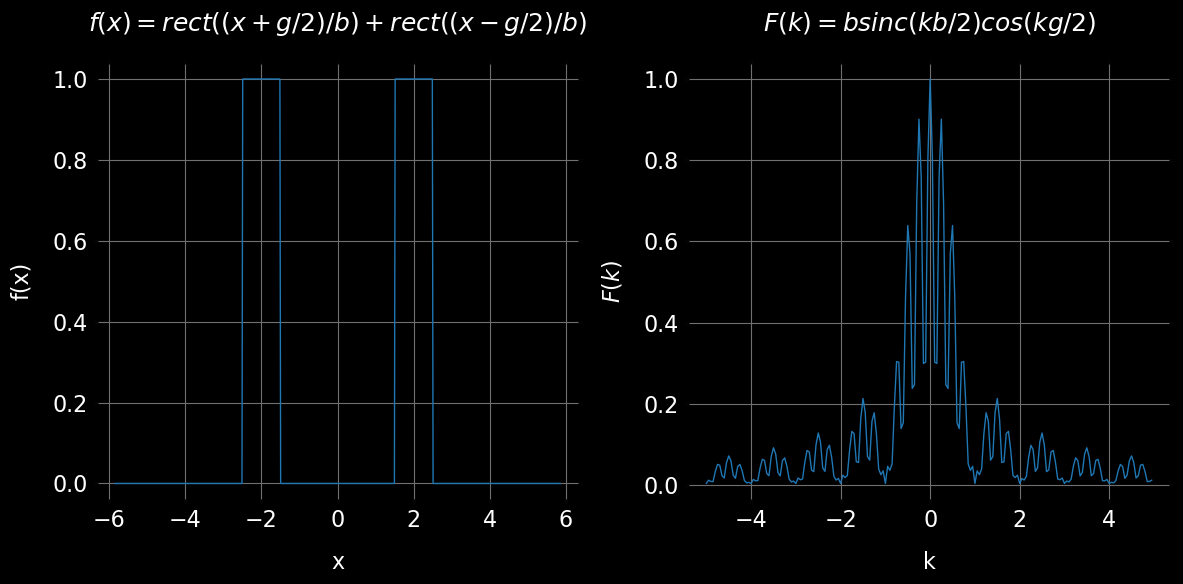

<IPython.core.display.Latex object>

In [3]:
b_width = 1
g_width = 4
def rect(x):
    return np.where(np.abs(x)<=b_width/2, 1, 0)


x = np.linspace(-10*b_width, 10*b_width, 1024)  
offset_1 = 100
offset_2 = 300


f1 = rect(x)
f2 = rect(x-g_width/2) + rect(x+g_width/2)

F1 = np.fft.fftshift(np.fft.fft(np.fft.fftshift(f1)))
F2 = np.fft.fftshift(np.fft.fft(np.fft.fftshift(f2)))

mid_ind_1 = F1.argmax()
mid_ind_2 = F2.argmax()

F1 = F1 / np.max(np.abs(F1))
F2 = F2 / np.max(np.abs(F2))

# Frequency axis
k = np.fft.fftshift(np.fft.fftfreq(len(x), x[1] - x[0]))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x[mid_ind_1-offset_1:mid_ind_1+offset_1], f1[mid_ind_1-offset_1:mid_ind_1+offset_1])
plt.title(r'$f(x) = rect(x/b)$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k[mid_ind_1-offset_1:mid_ind_1+offset_1], np.abs(F1)[mid_ind_1-offset_1:mid_ind_1+offset_1])
plt.title(r'$F(k) = bsinc(kb/2)$')
plt.xlabel('k')
plt.ylabel('$F(k)$')
plt.grid(True)
plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, i.1$: Single Slit Aperture $f(x)$ and $F(k)=FFT(f(x))$.'))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x[mid_ind_2-offset_2:mid_ind_2+offset_2], f2[mid_ind_2-offset_2:mid_ind_2+offset_2])
plt.title(r'$f(x) = rect((x+g/2)/b) + rect((x-g/2)/b)$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k[mid_ind_1-offset_1:mid_ind_1+offset_1], np.abs(F2)[mid_ind_1-offset_1:mid_ind_1+offset_1])
plt.title(r'$F(k) = bsinc(kb/2)cos(kg/2)$')
plt.xlabel('k')
plt.ylabel('$F(k)$')
plt.grid(True)

plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, i.2$: Double Slit Aperture $f(x)$ and $F(k)=FFT(f(x))$.'))

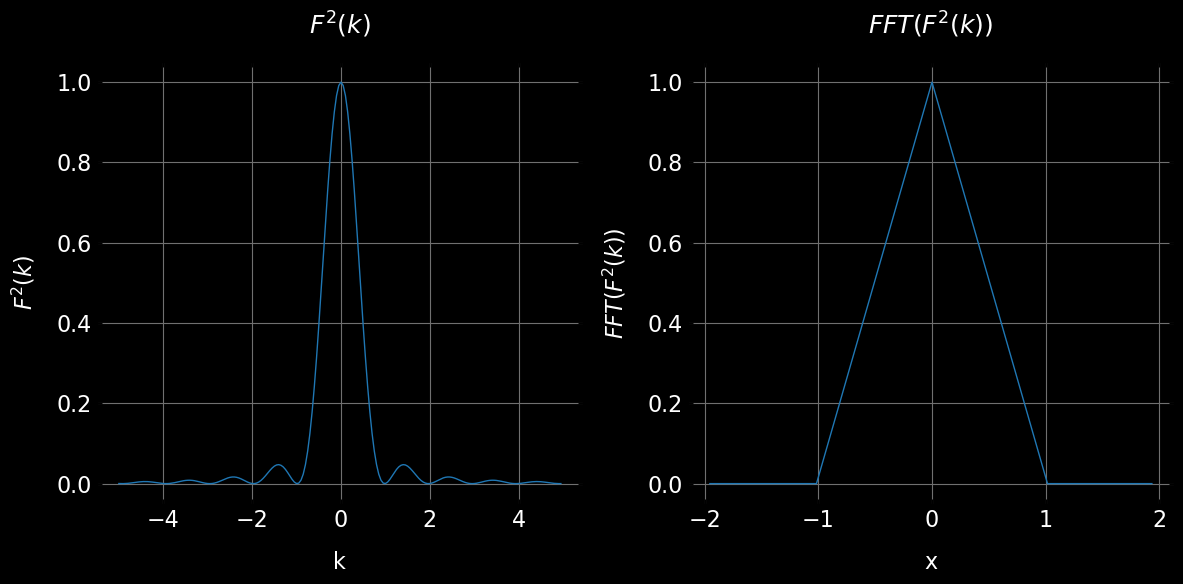

<IPython.core.display.Latex object>

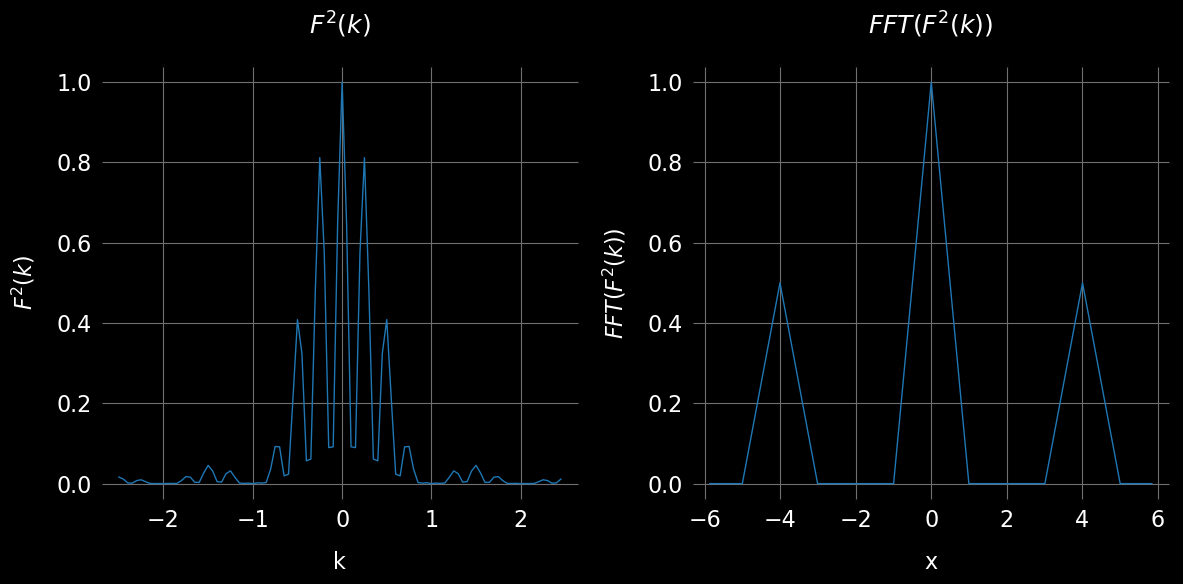

<IPython.core.display.Latex object>

In [4]:
I_k_1 = np.abs(F1)**2
I_k_2 = np.abs(F2)**2

x = np.fft.fftshift(np.fft.fftfreq(len(k), k[1] - k[0]))
f_x_1 = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(I_k_1)))
f_x_2 = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(I_k_2)))

f_x_1 = f_x_1/f_x_1.max()
f_x_2 = f_x_2/f_x_2.max()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k[mid_ind_1-offset_1:mid_ind_1+offset_1], I_k_1[mid_ind_1-offset_1:mid_ind_1+offset_1])
plt.title(r'$F^2(k)$')
plt.xlabel('k')
plt.ylabel(r'$F^2(k)$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[mid_ind_1-offset_1:mid_ind_1+offset_1], np.abs(f_x_1)[mid_ind_1-offset_1:mid_ind_1+offset_1])
plt.title(r'$FFT(F^2(k))$')
plt.xlabel('x')
plt.ylabel(r'$FFT(F^2(k))$')
plt.grid(True)
plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, i.3$: Single Slit Intensity $I \propto F^2(k)$ and $FFT(F^2(k))$.'))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k[mid_ind_1-offset_1//2:mid_ind_1+offset_1//2], I_k_2[mid_ind_1-offset_1//2:mid_ind_1+offset_1//2])
plt.title(r'$F^2(k)$')
plt.xlabel('k')
plt.ylabel(r'$F^2(k)$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[mid_ind_2-offset_2:mid_ind_2+offset_2], np.abs(f_x_2)[mid_ind_2-offset_2:mid_ind_2+offset_2])
plt.title(r'$FFT(F^2(k))$')
plt.xlabel('x')
plt.ylabel(r'$FFT(F^2(k))$')
plt.grid(True)
plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, i.4$: Double Slit Intensity $I \propto F^2(k)$ and $FFT(F^2(k))$.'))

## Task 1

### Task 1a

***Task Definition*** 

In the Fraunhofer regime, determine the slit width $b$ from the position of the minima for various diffraction orders

***Theoretical Basis***

Light passsing through a single slit creates a diffraction pattern on a camera placed behind the slit. This pattern consists of bright spots (maxima) where light interferes constructively and dark spots (minima) where it interferes destructively.

The positions of the minima of arbitrary order ($n$) obey the following equation:

$$b~sin\alpha_n = n\lambda$$ 

- Slit width: $b$
- Order of minima: $n$
- Wavelength of laser light: $\lambda = 635 nm$
- Angle between optical axis and $n$-th order minima: $\alpha_n$

Under small angle approximation $\alpha_n \approx 0$:

$$b~\alpha_n \approx n\lambda \label{eq1.1} \tag{1.1}$$ 

Geometrically, the relationship between $x_n$ and $\alpha_n$ is derived as:

$$x_n = f~tan\alpha_n $$ 

- Focal length of lens:  $f =300.8~mm$
- Distance between optical axis and n-th order minima: $x_n$

Under small angle approximation $\alpha_n \approx 0$:

$$x_n \approx f~\alpha_n \label{eq1.2} \tag{1.2}$$ 

Substituing [Eq 1.1](#mjx-eqn-eq1.1) into [Eq 1.2](#mjx-eqn-eq1.2) yields:

$$ x_n \approx f \frac{n\lambda}{b} \label{eq1.3} \tag{1.3}$$ 

$$ k \equiv \frac{f\lambda}{b}$$

$$b = \frac{f\lambda}{k}$$

The uncertainty is given by:

$$\mu_b = \left|\frac{\partial b}{\partial k}\right|\mu_k = \left|-\frac{b}{k}\right|\mu_k$$

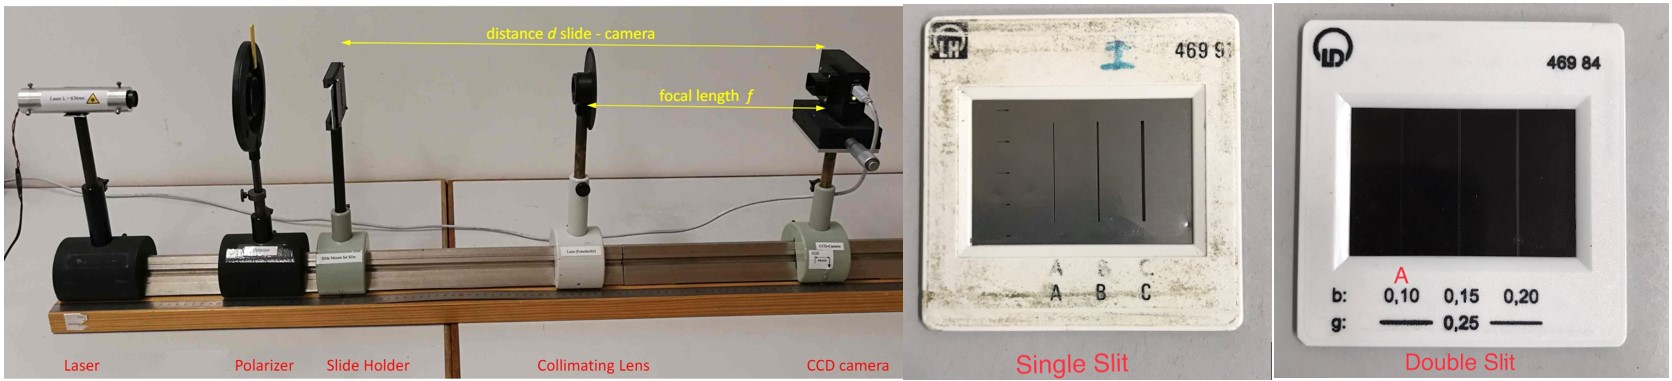

<IPython.core.display.Latex object>

In [5]:
dy(Im("./img/Setup2.jpg", height=100, width=900))
dy(Lx(r'$Figure\, 1.1$: Setup'))

***Procedure***

1. A single slit "469-91-A" was inserted into the slide holder, and an old camera recorded the diffraction pattern **Fig1.1**.
</br> 

2. During the experiment, the height of the optical elements were aligned to achieve the best diffraction pattern recording. 
</br>

3. Subsequently, the pixel data was processed and used to plot a graph of $x_n$ against $n$. 
<br>

4. The slit width $b$ was determined from linear regression using  [Eq 1.3](#mjx-eqn-eq1.3).


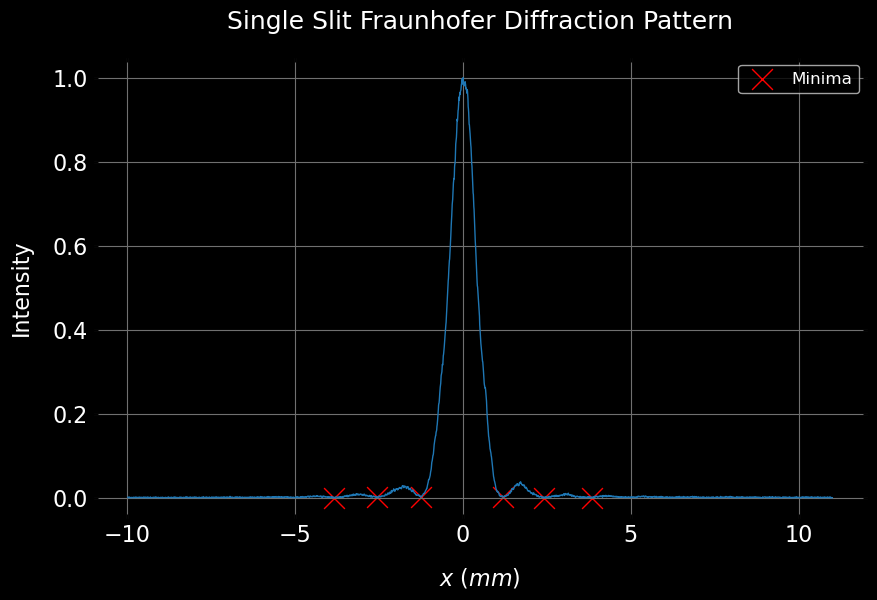

<IPython.core.display.Latex object>

In [6]:
file_path = data_dir + 'Task1_ab/SS_Fr_469_91_a.csv'

df = pd.read_csv(file_path, names=['x', 'I'])

x = np.array(df['x'], dtype=int)*pw # m
I = np.array(df['I'])
x = x - x[I.argmax()] # shift x to the max intensity
I = I/I.max()
minima_indices, _ = find_peaks(-I, height=-0.01, distance=100, prominence=0.0045)
plt.plot(x*1e3, I)
plt.scatter(x[minima_indices]*1e3, I[minima_indices], marker='x', label = 'Minima', color = 'r')
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Single Slit Fraunhofer Diffraction Pattern')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 1.2$: Single Slit Fraunhofer Diffraction Pattern'))

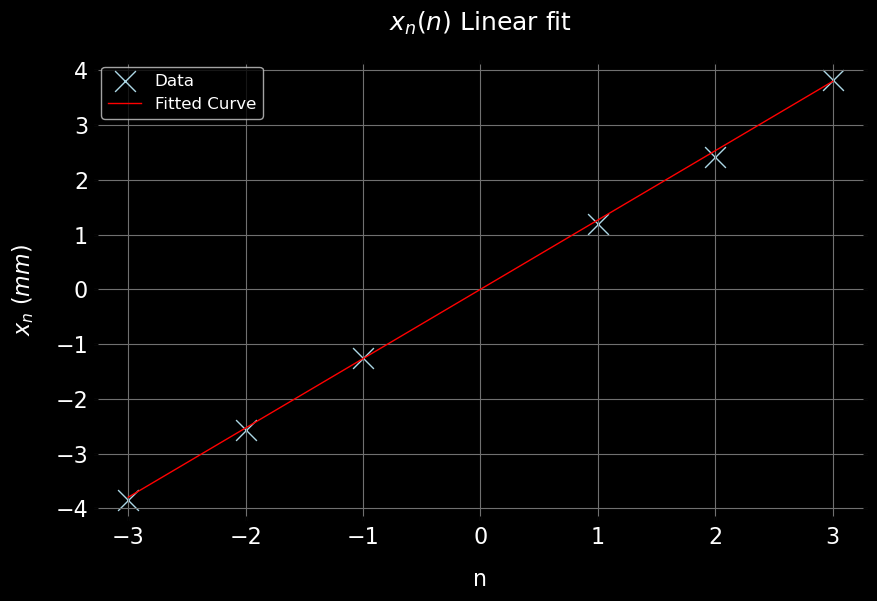

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
x_mins = x[minima_indices]
n = np.array(range(1, len(x_mins)//2+1))
n = np.sort(np.concatenate((-n, n))) # ordered symmetric list of orders e.g.: -3, -2, -1, 1, 2, 3

def y_x(x_arg, k_arg):
    return k_arg*x_arg
    
k, u_k_squared = fit_and_plot(n, x_mins*1e3, 'n', r'$x_n$ ($mm$)', '$x_n(n)$ Linear fit',  y_x)
dy(Lx(r'$Figure\, 1.3$: Linear fit of position with respect to minimum diffraction order.'))
ss_b_from_position = f*Lambda / k *1e3# single-slit b from position of minima
u_ss_b_from_position = ss_b_from_position / k * np.sqrt(u_k_squared)
dy(Lx(r'$$b = (%.2f \pm %.3f) ~mm $$' % (ss_b_from_position*1e3,u_ss_b_from_position*1e3)))

### Task 1b

***Task Definition*** 

In the Fraunhofer regime, determine the slit width $b$ from the Fast Fourier Transform (FFT) of the intensity profile.

***Theoretical Basis***

The camera records both the intensity ($I$) and the position ($x$) of the diffraction pattern.

The inverse Fourier transform of is given by:
$$ f(x) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(k_x) e^{i k_x x} \, dk_x $$

It is given that intensity $I$ is proportional to $F(k_x)$, which implies that $I$ is a function of $k_x$.

Hence, the aperture function f(x) in real space may be found by supplying the values of $I$ into the inverse Fourier Transform, which is acheived by applying an FFT to the discrete values of $I$.

Subsequently, the values of f(x) against $x$ is plotted, and used to determine the slit width $b$.

Additionally, a graph of $I$ against $k_x$ may be plotted for completeness using the transformation:

$$k_x = \frac{2\pi}{\lambda}\frac{x}{\sqrt{x^2 + f^2}}$$

We expect the graph to match the given thereotical equation of $I(k_x)$ for single slits:

$$ I = \text{sinc}^2 \left(\frac{k_x b}{2}\right) $$


- Focal length of lens: f = $300.8~mm$
- Wavelength of laser light: $\lambda = 635 nm$



***Procedure***

1. The intensity profile in real space is first shifted along to abscissa such that the peak intensity corresponding to the principal maximum is located at x=0. 
</br> 

2. Subseqeuntly, a graph of $I$ against $k_x$ is plotted for completeness using [Eq 1.4](#mjx-eqn-eq1.4).
</br>

3. An FFT is applied to values of $I$ to attain the values of the aperture function $f(x)$.
<br>

4. The slit width $b$ is determined from the graph


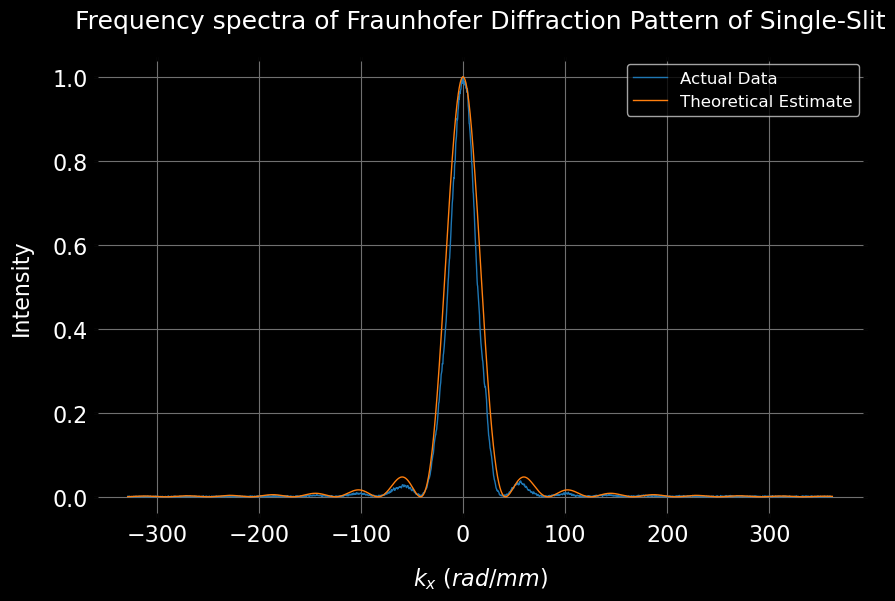

<IPython.core.display.Latex object>

In [8]:
k = 2*np.pi / Lambda * x / np.sqrt(x**2 + f**2)
I_th = np.sinc(k*ss_b_from_position/2/np.pi)**2
#k = 2*np.pi / Lambda * x / f
plt.plot(k*1e-3, I, label='Actual Data')
plt.plot(k*1e-3, I_th, label= 'Theoretical Estimate')
plt.xlabel(r'$k_x$ ($rad/mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Frequency spectra of Fraunhofer Diffraction Pattern of Single-Slit')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 1.4$: Frequency spectra of Fraunhofer Diffraction Pattern of Single-Slit.'))

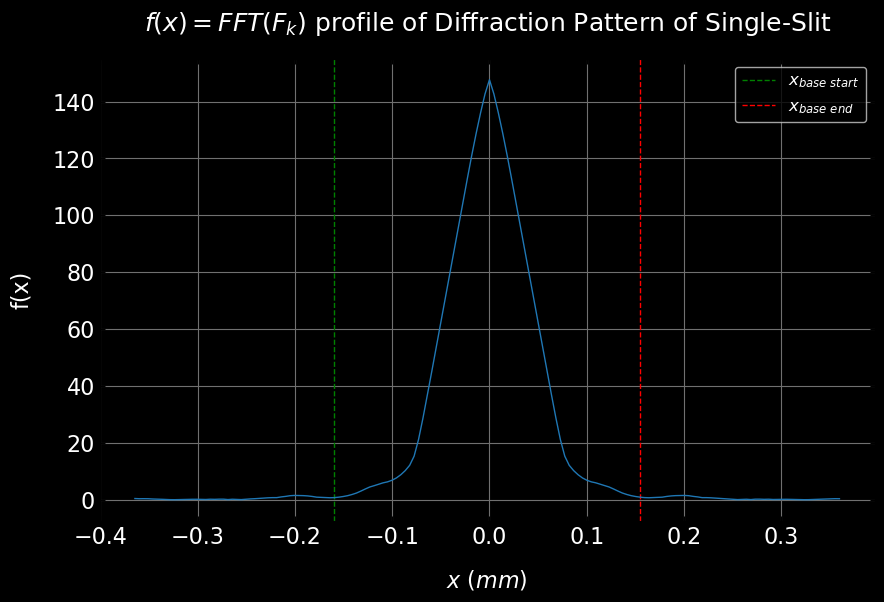

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
#F_k_fft = np.fft.ifft(I)
F_th = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(1.2*np.sinc(k*ss_b_from_position/np.pi)**2)))
F_k_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(I)))
freq = np.fft.fftshift(np.fft.fftfreq(len(k), d=np.gradient(k)/np.pi))
#plt.plot(freq*1e3, np.abs(F_k_fft))
F_k = np.abs(F_k_fft)
base_indices = (len(freq)//2-35) + np.where(F_k[len(freq)//2-35:len(freq)//2+35] > 0.7)[0]

# First and last indices of the base
base_start_index = base_indices[0]
base_end_index = base_indices[-1]
plt.axvline(freq[base_start_index]*1e3, color='g', linestyle='--', label=r'$x_{base~start}$')
plt.axvline(freq[base_end_index]*1e3, color='r', linestyle='--', label=r'$x_{base~end}$')
plt.plot(freq[len(freq)//2-80:len(freq)//2+80]*1e3, F_k[len(freq)//2-80:len(freq)//2+80])
#plt.plot(freq[len(freq)//2-80:len(freq)//2+80]*1e3, np.abs(F_th)[len(freq)//2-80:len(freq)//2+80])
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'f(x)')
plt.grid(True)
plt.legend()
plt.title(r'$f(x) = FFT(F_k)$ profile of Diffraction Pattern of Single-Slit')
plt.show()
dy(Lx(r'$Figure\, 1.5$: Fourier transformed profile of intensity of Single-Slit.'))
ss_b_from_base = 0.5*(freq[base_end_index] - freq[base_start_index])
dy(Lx(r'$$b = \frac{x_{base~end} - x_{base~start}}{2} \approx %.2f ~mm $$' % (ss_b_from_base*1e3)))

### Task 1c

***Task Definition***:

In the Fresnel regime, measure the diffraction pattern of a single slit for three distances $z$ between slit and camera. Comapre the measured diffraction patterns with theory.

***Theoretical Basis***

In the Fresnel regime, only the lens is removed, and the procedure from Task 1a is repeated. 

The theoretical graphs were plotted using the following formula:

$$
I_{theory} = \frac{1}{2} \left( \left| F\left(\frac{b + 2x}{\sqrt{2\lambda z}}\right) \right| + \left| F\left(\frac{b - 2x}{\sqrt{2\lambda z}}\right) \right| \right)^2
$$

$$ \int_{0}^{u} F(u) \exp\left(\frac{i \pi x}{2}\right) \, dx $$

A quantitative comparison between theoretical and actual graphs is made by analysing the coefficient of determination ($R^2$) value which is a measure of variance between the 2 graphs. 

\begin{align*}
\text{SS}_{\text{total}} &= \sum_{i=1}^{n} \left( y_i - \overline{y} \right)^2 \\
\text{SS}_{\text{residual}} &= \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 \\
R^2 &= 1 - \frac{\text{SS}_{\text{residual}}}{\text{SS}_{\text{total}}}
\end{align*}

- $\overline{y}$ : Mean of actual data
- $y_i$ : Actual values
- $\hat{y}_i$ : Predicted Values

A higher value of $R^2$ implies a better correlation between theoretical and actual values, up to a perfect correlation when $R^2=1$

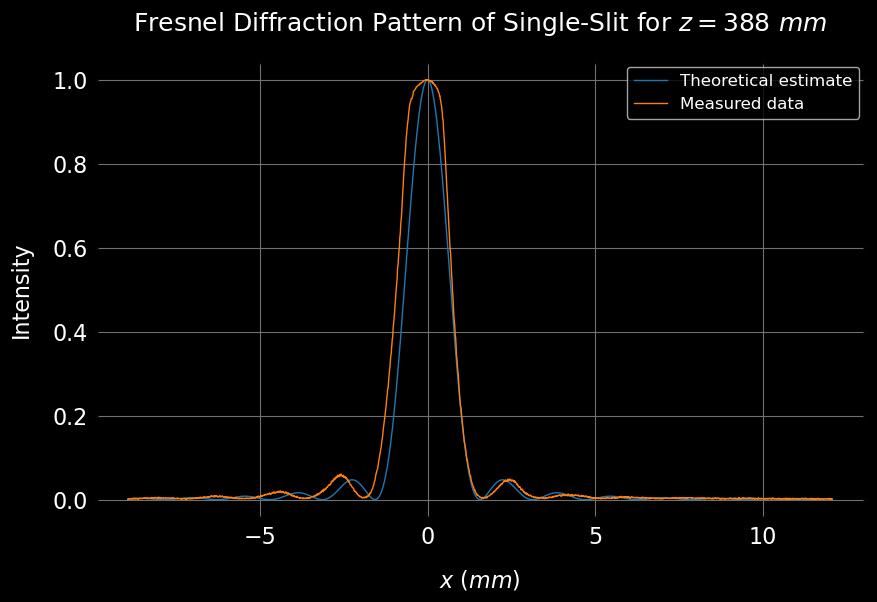

<IPython.core.display.Latex object>

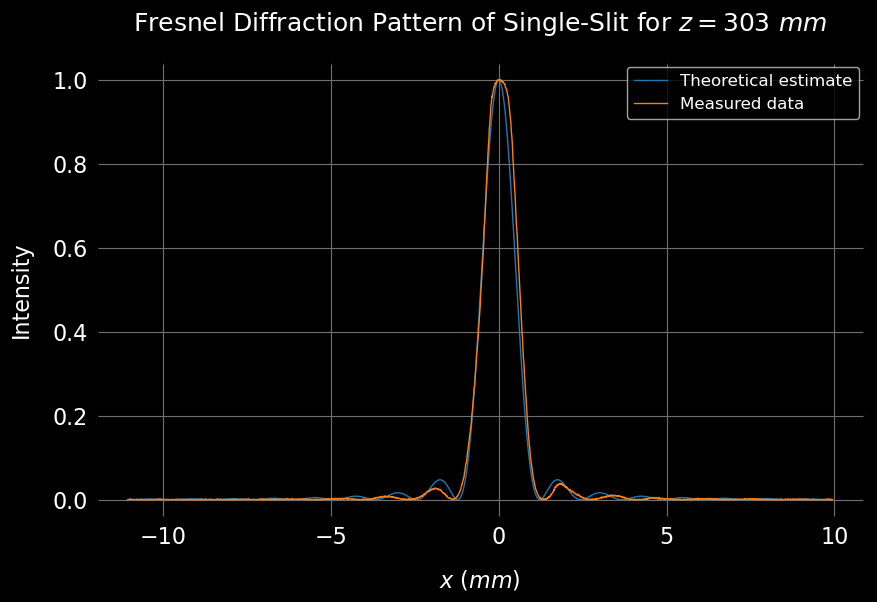

<IPython.core.display.Latex object>

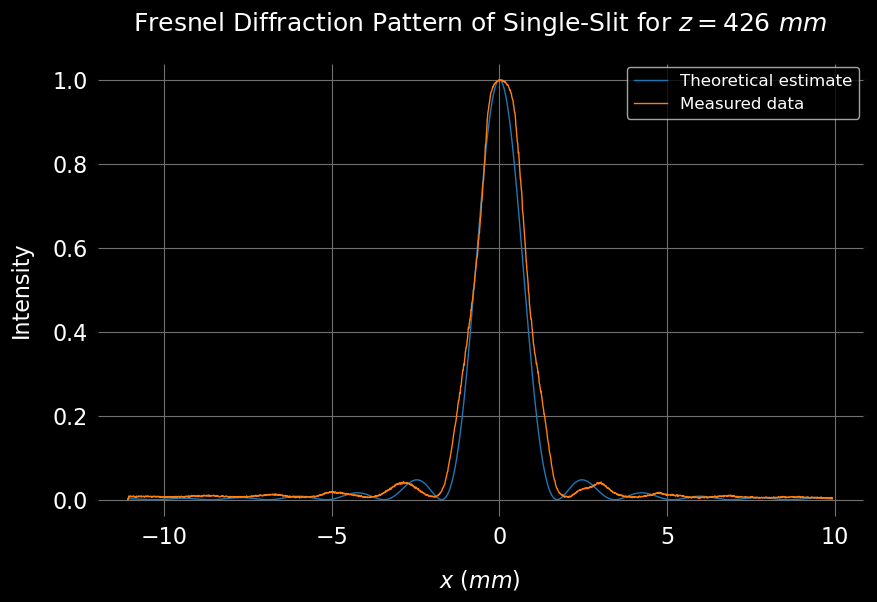

<IPython.core.display.Latex object>

In [10]:
task_dir = data_dir + 'Task1_c'
df_l = []
for path in os.listdir(task_dir):
    file_path = os.path.join(task_dir,path)
    if os.path.isfile(file_path): 
        df = pd.read_csv(file_path, names=['x', 'I'])
        x = np.array(df['x']) * pw 
        I = np.array(df['I'])
        I = I/I.max()
        x = x - x[I.argmax()]
        df_l.append(tuple([x,I]))
        
for i,d in enumerate(df_l):
    u_plus = (ss_b_from_base + 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_minus = (ss_b_from_base - 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    S_plus, C_plus = fresnel(u_plus)
    S_minus, C_minus = fresnel(u_minus)
    I_th = 0.5*((C_plus+C_minus)**2 + (S_plus+S_minus)**2)
    scaling_factor = d[1].max()/I_th.max()
    I_th = I_th*scaling_factor
    ss_total = np.sum((d[1] - np.mean(d[1])) ** 2)
    ss_residual = np.sum((d[1] - I_th) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    plt.plot(d[0]*1e3,I_th, label=r'Theoretical estimate')
    plt.plot(d[0]*1e3, d[1], label=r'Measured data')
    plt.title(r'Fresnel Diffraction Pattern of Single-Slit for $z = %d ~mm$' % (z_l[i]*1e3))
    plt.grid(True)
    plt.legend()
    plt.xlabel(r'$x$ ($mm$)')
    plt.ylabel(r'Intensity')
    plt.show()
    dy(Lx(r"$Figure\, 1.%d$: Fresnel Diffraction Pattern of Single-Slit ($z = %d ~mm$). $R^2 = %.2f $" % (6 + i, z_l[i]*1e3, r_squared)))
    

## Task 2

### Task 2a

***Task Definition***:

Measure the diffraction pattern of a double-slit in the Fraunhofer regime, and determine the slit distance $g$ from the position of the minima for various diffraction orders.

***Theoretical Basis***

Light passsing through a double slit creates a diffraction pattern on a camera placed behind the slit.

The positions of the minima of arbitrary order (n) obey the following equation:

$$g \sin(\alpha_n) = \left(n + \frac{1}{2}\right) \lambda$$


- Slit distance : $b$
- Order of minima: $n$
- Wavelength of laser light: $\lambda = 635 nm$
- Angle between optical axis and $n$-th order minima: $\alpha_n$

Under small angle approximation $\alpha_n \approx 0$:

$$x_n \approx \frac{f\lambda}{2g}(2n + 1) \label{eq2.1} \tag{2.1}$$ 

- Focal length of lens: $f = 300.8~mm$
- Distance between optical axis and n-th order minima: $x_n$

$$k \equiv \frac{f\lambda}{2g}$$

$$g = \frac{f\lambda}{2k}$$

The uncertainty is given by:

$$\mu_g = \left|\frac{\partial g}{\partial k}\right|\mu_k = \left|-\frac{g}{k}\right|\mu_k$$

***Procedure***

1. The procedure from Task 1a is repeated using the double slit "469-84-A" instead.
<br>

2. The slit distance $g$ was determined from linear regression using  [Eq 2.1](#mjx-eqn-eq2.1).

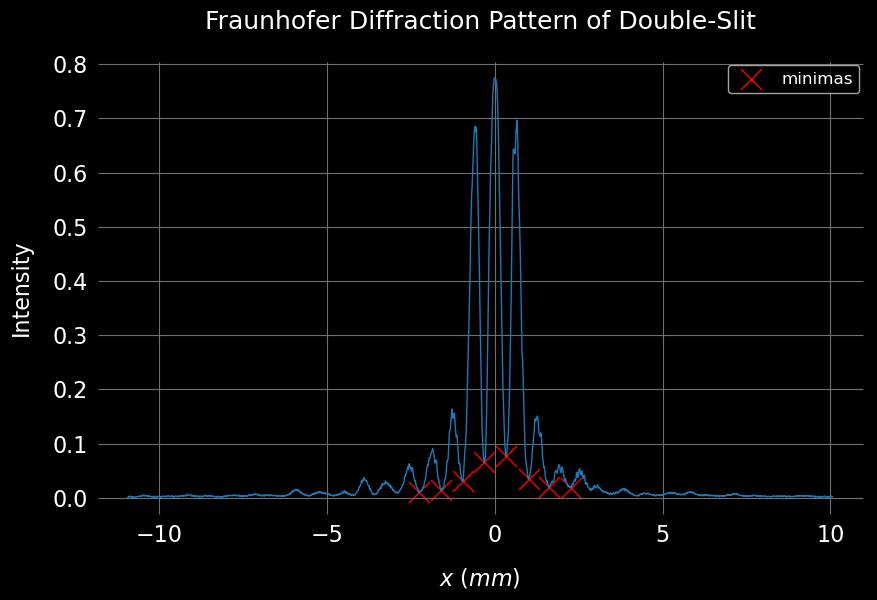

<IPython.core.display.Latex object>

In [11]:
file_path = data_dir + 'Task2_abc/DS_Fr_469_84_A.csv'

df = pd.read_csv(file_path, names=['x', 'I'])

x = np.array(df['x'], dtype=int)*pw # m
I = np.array(df['I'])
#I = I/I.max()
x = x - x[I.argmax()] # shift x to the max intensity

minima_indices, _ = find_peaks(-I, height=-0.1, distance=10, prominence=0.032)
plt.plot(x*1e3, I)
plt.scatter(x[minima_indices]*1e3, I[minima_indices], marker='x', label = 'minimas', color = 'r')
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Fraunhofer Diffraction Pattern of Double-Slit')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 2.1$: Fraunhofer Diffraction Pattern of Double-Slit.'))

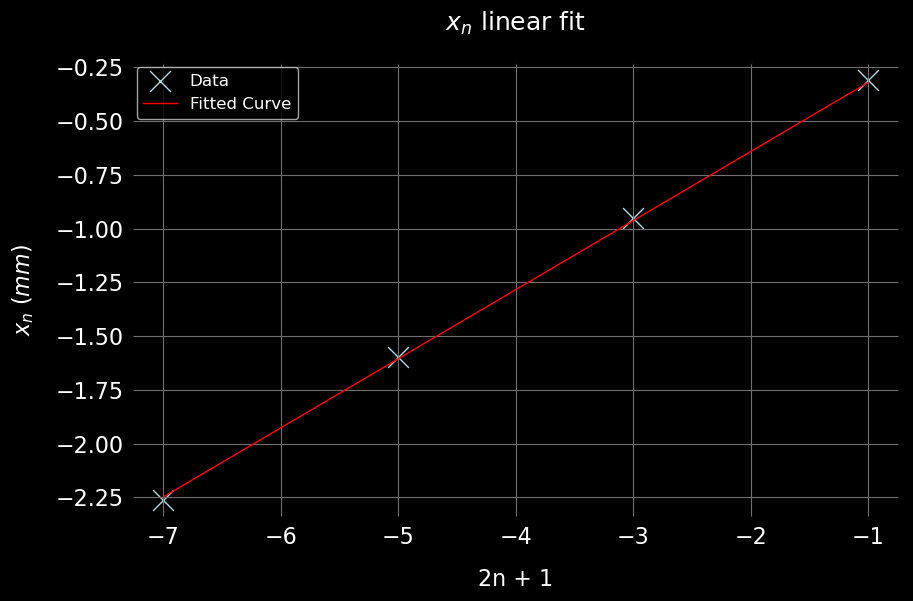

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [12]:
x_mins = x[minima_indices]
n = np.array(range(1, len(x_mins)//2+1))
n = np.sort(np.concatenate((-n, n))) # ordered symmetric list of orders e.g.: -3, -2, -1, 1, 2, 3

k, u_k_squared = fit_and_plot(2*n[:len(x_mins)//2]+1, x_mins[:len(x_mins)//2]*1e3, '2n + 1', r'$x_n$ ($mm$)', '$x_n$ linear fit',  y_x)
dy(Lx(r'$Figure\, 2.2$: Linear fit of position with respect to minimum diffraction order.'))
ds_g_from_position = f*Lambda / k/2 *1e3 # double-slit g from position of minima
u_ds_g_from_position = ds_g_from_position / k * np.sqrt(u_k_squared)
dy(Lx(r'$$g = (%.2f \pm %.3f) ~mm $$' % (ds_g_from_position*1e3,u_ds_g_from_position*1e3)))

### Task 2b

***Task Definition***:

Measure the diffraction pattern of a double-slit in the Fraunhofer regime, and determine the slit distance $g$ and the slit width $b$ from the fit of the Fraunhofer diffraction-pattern to the data

***Theoretical Basis***:

The theoretical Franuhofer diffraction pattern for double slits is given by:

$$ I = \text{sinc}^2 \left(\frac{k_x b}{2}\right){cos}^2 \left(\frac{k_x g}{2}\right) $$

$$k_x = \frac{2\pi}{\lambda}\frac{x}{\sqrt{x^2 + f^2}}$$

The actual data is fitted to the theoretical equation, and the values of $b$ and $g$ are determined from the fit.



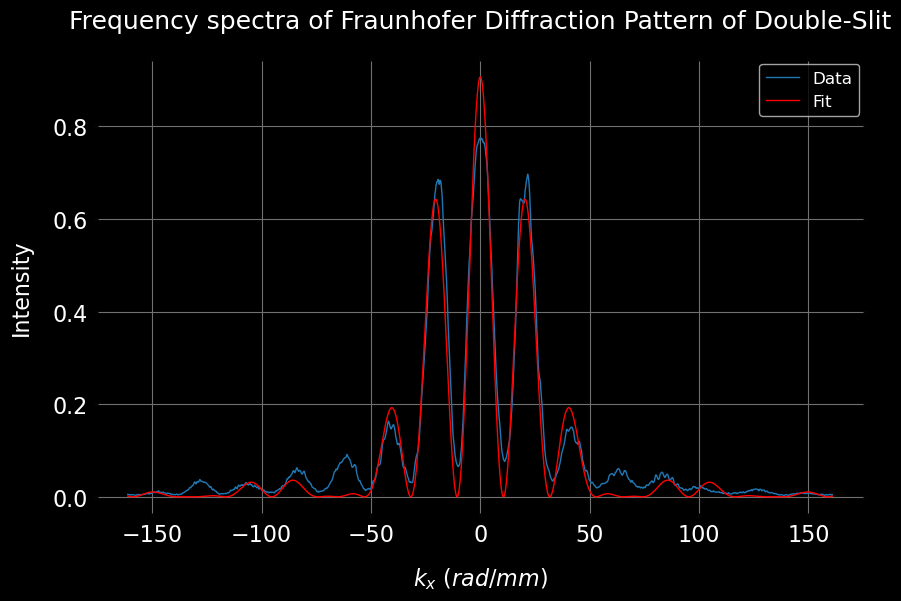

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
k = 2*np.pi / Lambda * x / np.sqrt(x**2 + f**2)
#k = 2*np.pi / Lambda * x / f
def ds_intensity(k_arg, b_arg, g_arg,A):
    eps = 1e-150
    return A*np.sinc(b_arg*k_arg/2 + eps)**2 * np.cos(g_arg*k_arg/2)**2

ds_fit = curve_fit(ds_intensity,k,I,p0=(1e-4,1e-4,1e-1))
offset_ind = 700
mid_ind = I.argmax()
plt.plot(k[mid_ind-offset_ind:mid_ind+offset_ind]*1e-3, I[mid_ind-offset_ind:mid_ind+offset_ind], label='Data')
plt.plot(k[mid_ind-offset_ind:mid_ind+offset_ind]*1e-3, ds_intensity(k, ds_fit[0][0],ds_fit[0][1],ds_fit[0][2])[mid_ind-offset_ind:mid_ind+offset_ind], label='Fit', color='r')
plt.xlabel(r'$k_x$ ($rad/mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Frequency spectra of Fraunhofer Diffraction Pattern of Double-Slit')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 2.3$: Frequency spectra of Fraunhofer Diffraction Pattern of Double-Slit.'))
ds_b_from_fit = ds_fit[0][0]
ds_g_from_fit = ds_fit[0][1]
u_ds_b_from_fit = np.sqrt(ds_fit[1][0][0])
u_ds_g_from_fit = np.sqrt(ds_fit[1][1][1])
dy(Lx(r'$$b = (%.2f \pm %.3f) ~\mu m = %.2f ~mm$$' % (ds_b_from_fit*1e6,u_ds_b_from_fit*1e6,ds_b_from_fit*1e3)))
dy(Lx(r'$$g = (%.2f \pm %.3f) ~\mu m = %.2f ~mm$$' % (ds_g_from_fit*1e6,u_ds_g_from_fit*1e6,ds_g_from_fit*1e3)))

### Task 2c

***Task Definition*** 

In the Fraunhofer regime, determine the slit distance $g$ and the slit width $b$ from the FFT of the intensity profile.

***Procedure***

1. The procedure from Task 1b is repeated using the double slit "469-84-A" instead.
<br>

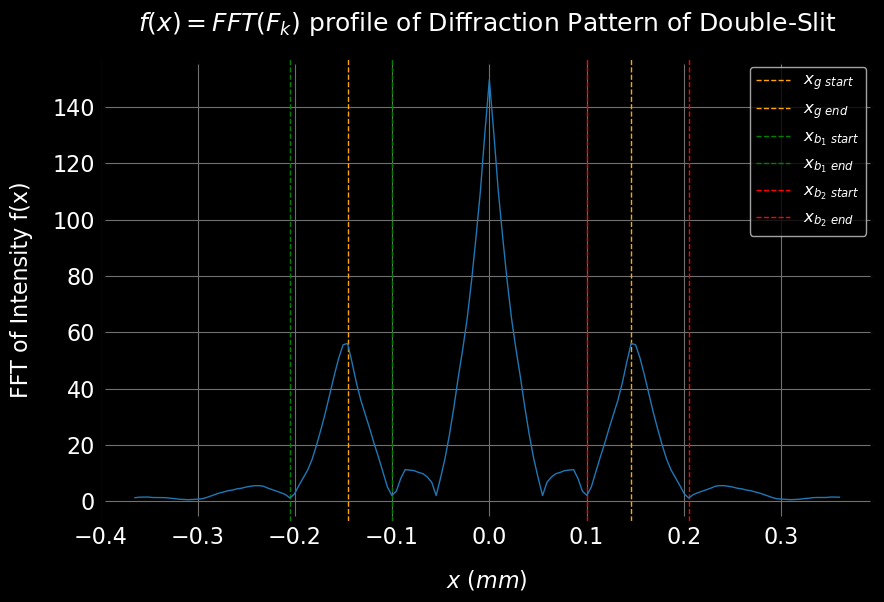

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
#F_k_fft = np.fft.ifft(I)
#F_th = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(1.2*np.sinc(k*ss_b_from_position/np.pi)**2)))
F_k_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(I)))
freq = np.fft.fftshift(np.fft.fftfreq(len(k), d=np.gradient(k)/np.pi))
#plt.plot(freq*1e3, np.abs(F_k_fft))
F_k = np.abs(F_k_fft)
mid_ind = F_k.argmax()
offset_ind = 30
left_F_k = F_k[mid_ind-2*offset_ind:mid_ind-offset_ind]
right_F_k = F_k[mid_ind+offset_ind:mid_ind+2*offset_ind]
left_peaks, _ = find_peaks(left_F_k, height=40)
left_peak = left_peaks[0] + mid_ind - 2*offset_ind
right_peaks, _ = find_peaks(right_F_k, height=40)
right_peak = right_peaks[0] + mid_ind + offset_ind
g_ind = [left_peak, right_peak]

offset_ind = 20
mid_ind = left_peak
tmp_F_k = F_k[mid_ind-offset_ind:mid_ind+offset_ind]
left_peaks, _ = find_peaks(-tmp_F_k, height=-10)
b_left = left_peaks + mid_ind-offset_ind

mid_ind = right_peak
tmp_F_k = F_k[mid_ind-offset_ind:mid_ind+offset_ind]
right_peaks, _ = find_peaks(-tmp_F_k, height=-10)
b_right = right_peaks + mid_ind-offset_ind

left_base_start = b_left[0]
left_base_end = b_left[-1]
right_base_start = b_right[0]
right_base_end = b_right[-1]


#plt.scatter(freq[g_ind]*1e3,F_k[g_ind], color='r', marker='x', label=r'$x_g$')
plt.axvline(freq[g_ind[0]]*1e3, color='orange', linestyle='--', label=r'$x_{g~start}$')
plt.axvline(freq[g_ind[1]]*1e3, color='orange', linestyle='--', label=r'$x_{g~end}$')
plt.axvline(freq[left_base_start]*1e3, color='g', linestyle='--', label=r'$x_{b_1~start}$')
plt.axvline(freq[left_base_end]*1e3, color='g', linestyle='--', label=r'$x_{b_1~end}$')
plt.axvline(freq[right_base_start]*1e3, color='r', linestyle='--', label=r'$x_{b_2~start}$')
plt.axvline(freq[right_base_end]*1e3, color='r', linestyle='--', label=r'$x_{b_2~end}$')
plt.plot(freq[len(freq)//2-80:len(freq)//2+80]*1e3, F_k[len(freq)//2-80:len(freq)//2+80])
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'FFT of Intensity f(x)')
plt.grid(True)
plt.legend()
plt.title(r'$f(x) = FFT(F_k)$ profile of Diffraction Pattern of Double-Slit')
plt.show()
dy(Lx(r'$Figure\, 2.4$: Fourier transformed profile of intensity of Double-Slit.'))
ds_b_from_fft = 0.25*(freq[left_base_end] - freq[left_base_start] + freq[right_base_end] - freq[right_base_start])
dy(Lx(r'$$b = \frac{1}{2}\left(\frac{x_{1_{base~end}} - x_{1_{base~start}}}{2} + \frac{x_{2_{base~end}} - x_{2_{base~start}}}{2} \right) \approx %.2f ~mm $$' % (ds_b_from_fft*1e3)))
ds_g_from_fft = freq[g_ind[1]] - freq[g_ind[0]]
dy(Lx(r'$$g = x_{g_2} - x_{g_1} \approx %.2f ~mm $$' % (ds_g_from_fft*1e3)))

### Task 2d

***Task Definition***:

In the Fresnel regime, measure the diffraction pattern of a double slit for three distances $z$ between slit and camera. Comapre the measured diffraction patterns with theory.

***Theoretical Basis***

The procedure from Task 1d is repeated using the double slit instead.

The theoretical graphs for the double slit were plotted using the following formula:

$$
I_{theory} = \frac{1}{2} \left( \left| F\left(\frac{g+ b + 2x}{\sqrt{2\lambda z}}\right) \right| + \left| F\left(\frac{g+ b - 2x}{\sqrt{2\lambda z}}\right) \right| - \left| F\left(\frac{g- b + 2x}{\sqrt{2\lambda z}}\right) \right| - \left| F\left(\frac{g- b - 2x}{\sqrt{2\lambda z}}\right) \right|\right)^2
$$

A similar quantitative analysis is performed using the $R^2$ value.

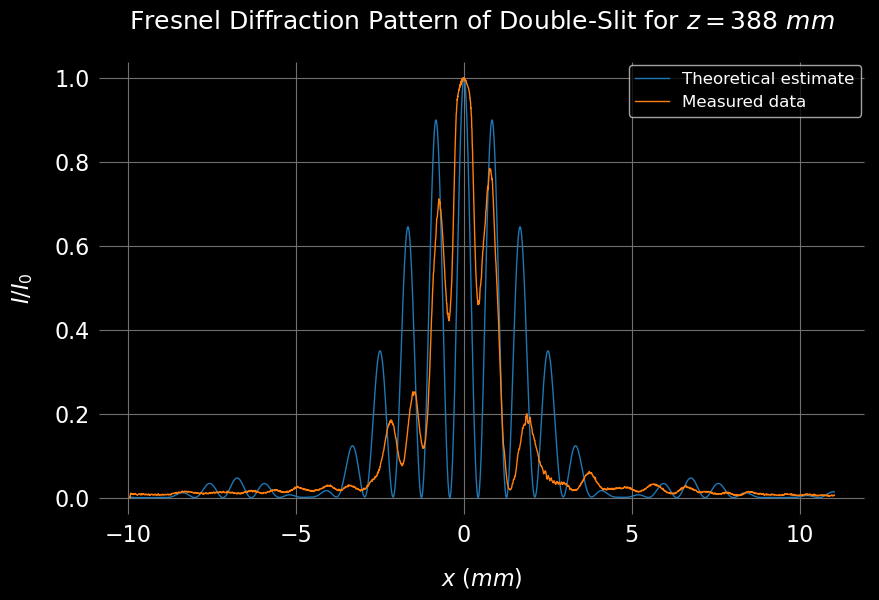

<IPython.core.display.Latex object>

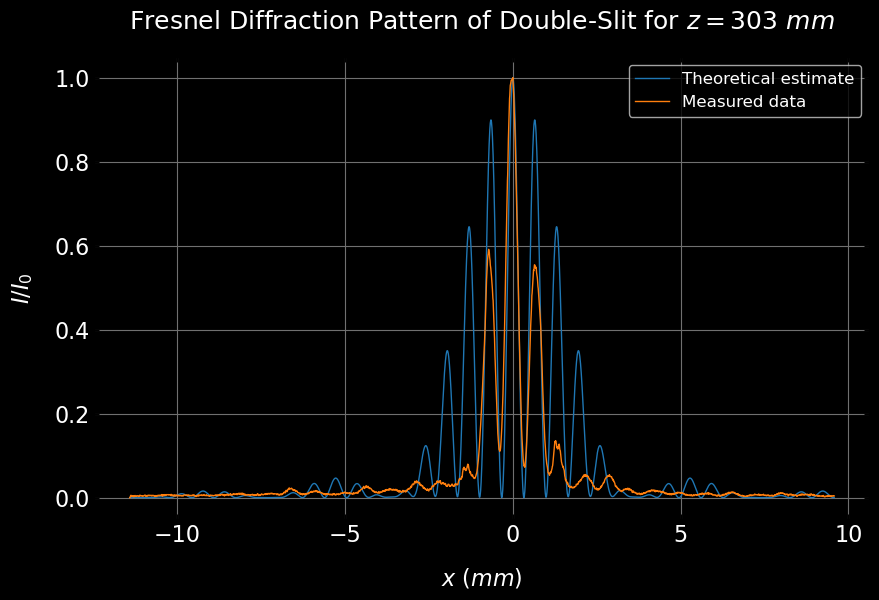

<IPython.core.display.Latex object>

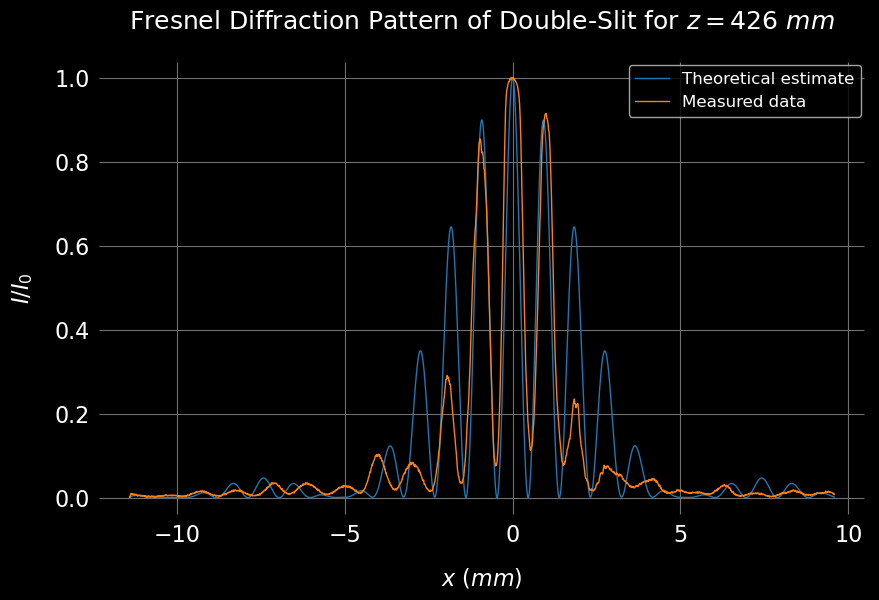

<IPython.core.display.Latex object>

In [15]:
task_dir = data_dir + 'Task2_d'
df_l = []
for path in os.listdir(task_dir):
    file_path = os.path.join(task_dir,path)
    if os.path.isfile(file_path): 
        df = pd.read_csv(file_path, names=['x', 'I'])
        x = np.array(df['x']) * pw 
        I = np.array(df['I'])
        I = I / I.max()
        x = x - x[I.argmax()]
        df_l.append(tuple([x,I]))
        
for i,d in enumerate(df_l):
    u_left_plus = (ds_g_from_fft - ds_b_from_fft + 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_left_minus = (ds_g_from_fft - ds_b_from_fft - 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_right_plus = (ds_g_from_fft + ds_b_from_fft + 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_right_minus = (ds_g_from_fft + ds_b_from_fft - 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    S_left_plus, C_left_plus = fresnel(u_left_plus)
    S_right_plus, C_right_plus = fresnel(u_right_plus)
    S_left_minus, C_left_minus = fresnel(u_left_minus)
    S_right_minus, C_right_minus = fresnel(u_right_minus)
    I_th = 0.5*((C_right_plus+C_right_minus-C_left_plus-C_left_minus)**2 + (S_right_plus+S_right_minus-S_left_plus-S_left_minus)**2)
    scaling_factor = d[1].max()/I_th.max()
    I_th = I_th*scaling_factor
    ss_total = np.sum((d[1] - np.mean(d[1])) ** 2)
    ss_residual = np.sum((d[1] - I_th) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    plt.plot(d[0]*1e3,I_th, label=r'Theoretical estimate')
    plt.plot(d[0]*1e3, d[1], label=r'Measured data')
    plt.title(r'Fresnel Diffraction Pattern of Double-Slit for $z = %d ~mm$' % (z_l[i]*1e3))
    plt.grid(True)
    plt.legend()
    plt.xlabel(r'$x$ ($mm$)')
    plt.ylabel(r'$I/I_0$')
    plt.show()
    dy(Lx(r"$Figure\, 2.%d$: Fresnel Diffraction Pattern of Double-Slit ($z = %d ~mm$). $R^2 = %.2f $" % (5 + i, z_l[i]*1e3, r_squared)))
    

***References***

1) [O17e Lab instruction](https://moodle2.uni-leipzig.de/pluginfile.php/3683853/mod_resource/content/1/O17e_2024.pdf)
